In [2]:
from glob import glob

import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_dir = r"D:\NUS_TERM2_CA2\Train"
print(os.listdir(train_dir))

validation_dir = r"D:\NUS_TERM2_CA2\Validation"
print(os.listdir(validation_dir))


['food', 'landmark', 'people']
['food', 'landmark', 'people']


# Model Configuration

In [16]:
def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
  
  convLyr = Conv2D(numFilters,
                  kernel_size=kernelSz,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4),
                  name=lyrName+'_conv' if lyrName else None)
  x = inputs
  if convFirst:
    x = convLyr(x)
    if batchNorm:
      x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
    if activation is not None:
      x = Activation(activation, name=lyrName+'_'+activation if lyrName else None)(x)
  else:
    if batchNorm:
      x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
    if activation is not None:
      x = Activation(activation, name=lyrName+'_'+activation if lyrName else None)(x) 
    x = convLyr(x)

  return x

In [17]:
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
  x = inputs
  for run in range(0, numBlocks):
    strides = 1
    blkStr = str(run + 1)
    if downsampleOnFirst and run == 0:
      strides = 2
    y = resLyr(inputs=x,
              numFilters=numFilters,
              strides=strides,
              lyrName=names+'_blk'+blkStr+'_Res1' if names else None)
    y = resLyr(inputs=y,
              numFilters=numFilters,
              activation=None,
              lyrName=names+'_blk'+blkStr+'_Res2' if names else None)
    if downsampleOnFirst and run == 0:
      x = resLyr(inputs=x,
                numFilters=numFilters,
                kernelSz=1,
                strides=strides,
                activation=None,
                batchNorm=False,
                lyrName=names+'_blk'+blkStr+'_lin' if names else None)
    x = add([x,y],
            name=names+'_Blk'+blkStr+'_add' if names else None)
    x = Activation('relu', name=names+'_Blk'+blkStr+'_relu' if names else None)(x)
        
  return x

In [18]:
def createResNetV1(inputShape=(32,32,3),
                   numClasses=3):
  inputs = Input(shape=inputShape)
  v = resLyr(inputs, lyrName='inpt')
  v = resBlkV1(inputs=v,
              numFilters=16,
              numBlocks=3,
              downsampleOnFirst=False,
              names='Stg1')
  v = resBlkV1(inputs=v,
              numFilters=32,
              numBlocks=3,
              downsampleOnFirst=True,
              names='Stg2')
  v = resBlkV1(inputs=v,
              numFilters=64,
              numBlocks=3,
              downsampleOnFirst=True,
              names='Stg3')
  
  '''v = resLyr(inputs=v,
            numFilters=64,
            kernelSz=3,
            strides=1,
            activation='relu',
            batchNorm=True,
            convFirst=True,
            lyrName='NEW'
            )'''
  
  v = AveragePooling2D(pool_size=8, name='AvgPool')(v)
  
  v = Flatten()(v)
  outputs = Dense(numClasses,
                 activation='softmax',
                 kernel_initializer='he_normal')(v)
  
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='categorical_crossentropy',
               optimizer='rmsprop',
               metrics=['accuracy'])
  
  return model

In [19]:
model = createResNetV1()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
inpt_conv (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
inpt_bn (BatchNormalization)    (None, 32, 32, 16)   64          inpt_conv[0][0]                  
__________________________________________________________________________________________________
inpt_relu (Activation)          (None, 32, 32, 16)   0           inpt_bn[0][0]                    
____________________________________________________________________________________________

__________________________________________________________________________________________________
Stg2_Blk2_add (Add)             (None, 16, 16, 32)   0           Stg2_Blk1_relu[0][0]             
                                                                 Stg2_blk2_Res2_bn[0][0]          
__________________________________________________________________________________________________
Stg2_Blk2_relu (Activation)     (None, 16, 16, 32)   0           Stg2_Blk2_add[0][0]              
__________________________________________________________________________________________________
Stg2_blk3_Res1_conv (Conv2D)    (None, 16, 16, 32)   9248        Stg2_Blk2_relu[0][0]             
__________________________________________________________________________________________________
Stg2_blk3_Res1_bn (BatchNormali (None, 16, 16, 32)   128         Stg2_blk3_Res1_conv[0][0]        
__________________________________________________________________________________________________
Stg2_blk3_

# Data Flow into Model For Accuracy Evaluation

In [20]:
def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 160:
        lr  *= 0.5e-3
        
    elif epoch > 140:
        lr  *= 1e-3
        
    elif epoch > 120:
        lr  *= 1e-2
        
    elif epoch > 80:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    
    return lr

LRScheduler = LearningRateScheduler(lrSchedule)

In [21]:
modelname = 'createResNetV1'
filepath = modelname + '.hdf5'

checkpoint = ModelCheckpoint(filepath,
                            monitor='val_acc',
                            verbose=0,
                            save_best_only=True,
                            mode='max')

csv_logger = CSVLogger(modelname + '.csv')
callbacks_list = [checkpoint, csv_logger, LRScheduler]

In [26]:
datagen = ImageDataGenerator(
      width_shift_range=0.1,
  height_shift_range=0.1,
                             rotation_range=90,
                             horizontal_flip=True,
                             vertical_flip=False,
    rescale=1./255)

batch_size = 128
img_width, img_height = 32, 32

In [27]:
train_generator = datagen.flow_from_directory(
  directory=train_dir ,
  target_size=(img_width, img_height),
  color_mode='rgb',
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=False
)

Found 2423 images belonging to 3 classes.


In [28]:
datagen2 = ImageDataGenerator(
    rescale=1./255)

batch_size = 128
img_width, img_height = 32, 32

In [29]:
validation_generator = datagen2.flow_from_directory(
  directory=validation_dir ,
  target_size=(img_width, img_height),
  color_mode='rgb',
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=False)

Found 724 images belonging to 3 classes.


In [31]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    epochs=40,
                    workers=8, 
                    shuffle=True,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=callbacks_list)

Learning rate:  0.001
Epoch 1/40
18/18 [==============================] - ETA: 4:55 - loss: 0.7893 - acc: 0.765 - ETA: 2:19 - loss: 1.5575 - acc: 0.382 - ETA: 1:38 - loss: 1.3787 - acc: 0.481 - ETA: 51s - loss: 1.3785 - acc: 0.412 - ETA: 39s - loss: 1.2797 - acc: 0.49 - ETA: 24s - loss: 1.4714 - acc: 0.38 - ETA: 17s - loss: 1.4267 - acc: 0.40 - ETA: 18s - loss: 1.3902 - acc: 0.40 - ETA: 11s - loss: 1.3357 - acc: 0.41 - ETA: 9s - loss: 1.4195 - acc: 0.3875 - ETA: 6s - loss: 1.4262 - acc: 0.361 - ETA: 2s - loss: 1.3728 - acc: 0.385 - 56s 3s/step - loss: 1.3163 - acc: 0.4200 - val_loss: 1.2382 - val_acc: 0.4641
Learning rate:  0.001
Epoch 2/40
18/18 [==============================] - ETA: 0s - loss: 0.2893 - acc: 1.000 - ETA: 1:17 - loss: 0.2651 - acc: 1.000 - ETA: 48s - loss: 1.3195 - acc: 0.666 - ETA: 53s - loss: 1.2624 - acc: 0.56 - ETA: 30s - loss: 1.2553 - acc: 0.54 - ETA: 25s - loss: 1.3486 - acc: 0.50 - ETA: 23s - loss: 1.3433 - acc: 0.50 - ETA: 19s - loss: 1.2629 - acc: 0.55 - ETA

18/18 [==============================] - ETA: 0s - loss: 0.1745 - acc: 1.000 - ETA: 0s - loss: 0.4857 - acc: 0.927 - ETA: 0s - loss: 0.3928 - acc: 0.956 - ETA: 0s - loss: 0.3511 - acc: 0.968 - ETA: 0s - loss: 0.3922 - acc: 0.906 - ETA: 0s - loss: 0.4481 - acc: 0.882 - ETA: 4s - loss: 0.4596 - acc: 0.886 - ETA: 3s - loss: 0.4177 - acc: 0.902 - ETA: 5s - loss: 0.4008 - acc: 0.909 - ETA: 3s - loss: 0.3919 - acc: 0.915 - 57s 3s/step - loss: 0.3669 - acc: 0.9245 - val_loss: 1.4141 - val_acc: 0.2188
Learning rate:  0.001
Epoch 16/40
18/18 [==============================] - ETA: 0s - loss: 0.1599 - acc: 1.000 - ETA: 0s - loss: 0.2941 - acc: 1.000 - ETA: 0s - loss: 0.4996 - acc: 0.856 - ETA: 0s - loss: 0.4709 - acc: 0.897 - ETA: 0s - loss: 0.5062 - acc: 0.870 - ETA: 0s - loss: 0.4819 - acc: 0.884 - ETA: 5s - loss: 0.4628 - acc: 0.893 - ETA: 4s - loss: 0.6056 - acc: 0.824 - ETA: 2s - loss: 0.5951 - acc: 0.833 - ETA: 2s - loss: 0.5681 - acc: 0.844 - ETA: 1s - loss: 0.5444 - acc: 0.853 - 58s 3s/s

KeyboardInterrupt: 

In [ ]:
model2 = createResNetV1()

model2.load_weights(filepath)
model2.compile(loss='categorical_crossentropy',
              optimize='adam',
              metrics=['accuracy'])

In [ ]:
predicts = model2.predict(validation_x)

predout = np.argmax(predicts, axis=1)
testout = np.argmax(validation_y, axis=1)

labelname = ['food', 'landmark', 'people']

testScore = metrics.accruacy_score(testout, predout)
confusion = metrics.confusion_matrix(testout, predout)


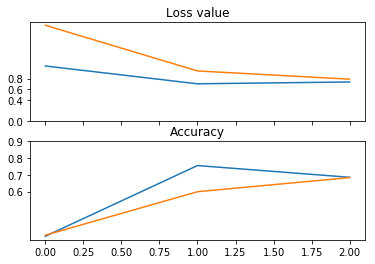

In [0]:
records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0.00,0.40,0.60,0.80])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9])
plt.title('Accuracy',fontsize=12)
plt.show()